In [1]:
name = 'G0.9_ssbs400_d20_MINE' # filename to load/save the results
chkpt_name = name+'.pt'
fig_name = name+'.pdf'

In [2]:
import numpy as np
import torch
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact

from IPython import display

import os

%matplotlib auto

Using matplotlib backend: MacOSX


In [3]:
from model.mine import MINE
from data.gaussian import Gaussian

In [4]:
np.random.seed(0)
torch.manual_seed(0)

## Data

In [5]:
sample_size = 400
rho = 0.9

In [6]:
rep = 1 # number of repeated runs
d = 20
X = np.zeros((rep,sample_size,d))
Y = np.zeros((rep,sample_size,d))
for i in range(rep):
    for j in range(d):
        data = Gaussian(sample_size=sample_size,rho=rho).data
        X[i,:,j] = data[:,0]
        Y[i,:,j] = data[:,1]

Generate the reference samples by resampling.

In [23]:
plt.scatter(X[0,:,0],Y[0,:,0],label="data",marker="+",color="steelblue")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot of data samples')

Text(0.5,1,'Plot of data samples')

## MI estimation

### Choice of parameters

In [7]:
batch_size = int(sample_size*1)
lr = 1e-5
ma_rate = 0.1

### Initialization

In [8]:
mine_list = []
for i in range(rep):
    mine_list.append(MINE(torch.Tensor(X[i]),torch.Tensor(Y[i]),batch_size=batch_size,lr=lr,ma_rate=ma_rate))
dXY_list = np.zeros((rep,0))

In [10]:
load_available = True
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(chkpt_name,map_location = 'cuda' if torch.cuda.is_available() else 'cpu')
    dXY_list = checkpoint['dXY_list']
    mine_state_list = checkpoint['mine_state_list']
    for i in range(rep):
        mine_list[i].load_state_dict(mine_state_list[i])

### Training

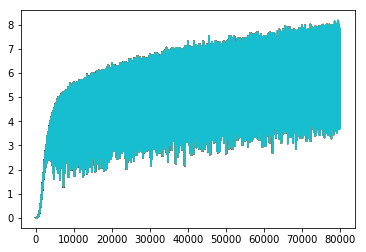

In [10]:
for k in range(400):
    for j in range(200):
        dXY_list = np.append(dXY_list,np.zeros((rep,1)),axis=1)
        for i in range(rep):
            mine_list[i].step()
            dXY_list[i,-1] = mine_list[i].forward()
        # To show intermediate works
    for i in range(rep):
        plt.plot(dXY_list[i,:])
    display.clear_output(wait=True)
    display.display(plt.gcf())
display.clear_output()

In [11]:
mine_state_list = [mine_list[i].state_dict() for i in range(rep)]

In [12]:
torch.save({
    'dXY_list' : dXY_list,
    'mine_state_list' : mine_state_list
},chkpt_name)

## Analysis

Ground truth mutual information

In [13]:
mi = - 0.5 * np.log(1-rho **2) * d
print(mi)

16.607312068216512


Apply moving average to smooth out the mutual information estimate.

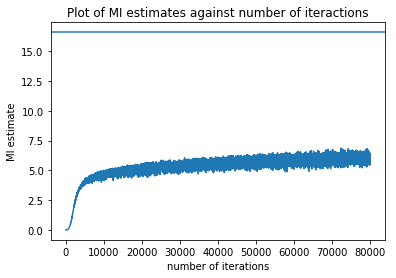

In [15]:
ma_rate = 0.1
mi_list = dXY_list.copy()
for i in range(1,dXY_list.shape[1]):
    mi_list[:,i] = (1-ma_rate) * mi_list[:,i-1] + ma_rate * mi_list[:,i]
for i in range(rep):
    plt.plot(mi_list[i,:])
plt.axhline(mi)
plt.title("Plot of MI estimates against number of iteractions")
plt.xlabel("number of iterations")
plt.ylabel("MI estimate")
plt.savefig(fig_name)

In [16]:
mine_list[0].state_dict()

{'XY_net': OrderedDict([('fc1.weight',
               tensor([[ 0.0439,  0.0510,  0.0441,  ..., -0.0120,  0.0557, -0.0672],
                       [-0.0412, -0.0554,  0.0292,  ..., -0.0499, -0.0705, -0.0481],
                       [-0.0200,  0.0132,  0.0468,  ...,  0.0622, -0.0529,  0.0512],
                       ...,
                       [-0.0396, -0.0262, -0.0086,  ...,  0.0105, -0.0098, -0.0417],
                       [ 0.0598, -0.0658,  0.0554,  ..., -0.0182,  0.0318,  0.0260],
                       [ 0.0362,  0.0624, -0.0686,  ..., -0.0171, -0.0360,  0.0501]])),
              ('fc1.bias',
               tensor([-0.0878, -0.0859, -0.0844, -0.0168, -0.0869, -0.0825, -0.0126, -0.0898,
                       -0.0225, -0.0121, -0.0148, -0.0847, -0.0783, -0.0129, -0.0815, -0.0109,
                       -0.0861, -0.0169, -0.0145, -0.0812, -0.0841, -0.0867, -0.0207, -0.0134,
                       -0.0143, -0.0853, -0.0832, -0.0866, -0.0087, -0.0852, -0.0119, -0.0763,
             